# Projet de Machine Learning : Prédiction des Livraisons en Retard (CRISP-DM)

## 1. Business Understanding (Compréhension du métier)


L'objectif de ce projet est de construire un modèle de classification capable de prédire si une commande sera livrée à l'heure ou en retard pour une entreprise de logistique intra-urbaine en Inde. La prédiction de ces retards permettra à l'entreprise de réduire le nombre de livraisons en retard, améliorant ainsi la satisfaction client et l'efficacité opérationnelle.

**Objectif Métier (BO1)** : Réduire le nombre de livraisons en retard.
**Objectif Data Science (DSO1)** : Construire un modèle de classification qui prédit si une commande sera livrée à l’heure ou en retard.

**Contexte de l'entreprise** :
Notre client est le principal marché indien pour la logistique intra-urbaine, avec une mission d'améliorer les moyens de subsistance de plus de 150 000 chauffeurs-partenaires. L'entreprise collabore avec divers restaurants pour faciliter la livraison directe de leurs produits aux consommateurs. En tirant parti d'un réseau de partenaires de livraison provenant de divers établissements, le client cherche à fournir aux clients des estimations précises des délais de livraison basées sur des facteurs tels que leur commande, leur emplacement et les partenaires de livraison disponibles.


## 2. Data Understanding (Compréhension des données)


Cette phase vise à explorer le jeu de données pour en comprendre la structure, la qualité et les caractéristiques initiales.

**Description des données** :
Chaque ligne correspond à une livraison unique. Les colonnes incluent :
- `market_id`: ID du marché.
- `created_at`: Horodatage de la commande.
- `actual_delivery_time`: Horodatage de la livraison réelle.
- `store_id`: ID du restaurant.
- `store_primary_category`: Catégorie principale du restaurant.
- `order_protocol`: Protocole de commande.
- `total_items`: Nombre total d'articles.
- `subtotal`: Prix final de la commande.
- `num_distinct_items`: Nombre d'articles distincts.
- `min_item_price`: Prix de l'article le moins cher.
- `max_item_price`: Prix de l'article le plus cher.
- `total_onshift_partners`: Nombre de partenaires de livraison en service.
- `total_busy_partners`: Nombre de partenaires de livraison occupés.
- `total_outstanding_orders`: Nombre total de commandes en attente.


### Aperçu des 5 premières lignes du DataFrame :
|   market_id | created_at          | actual_delivery_time   | store_id                         | store_primary_category   |   order_protocol |   total_items |   subtotal |   num_distinct_items |   min_item_price |   max_item_price |   total_onshift_partners |   total_busy_partners |   total_outstanding_orders |
|------------:|:--------------------|:-----------------------|:---------------------------------|:-------------------------|-----------------:|--------------:|-----------:|---------------------:|-----------------:|-----------------:|-------------------------:|----------------------:|---------------------------:|
|           1 | 2015-02-06 22:24:17 | 2015-02-06 23:27:16    | df263d996281d984952c07998dc54358 | american                 |                1 |             4 |       3441 |                    4 |              557 |             1239 |                      nan |                    14 |                         21 |
|        

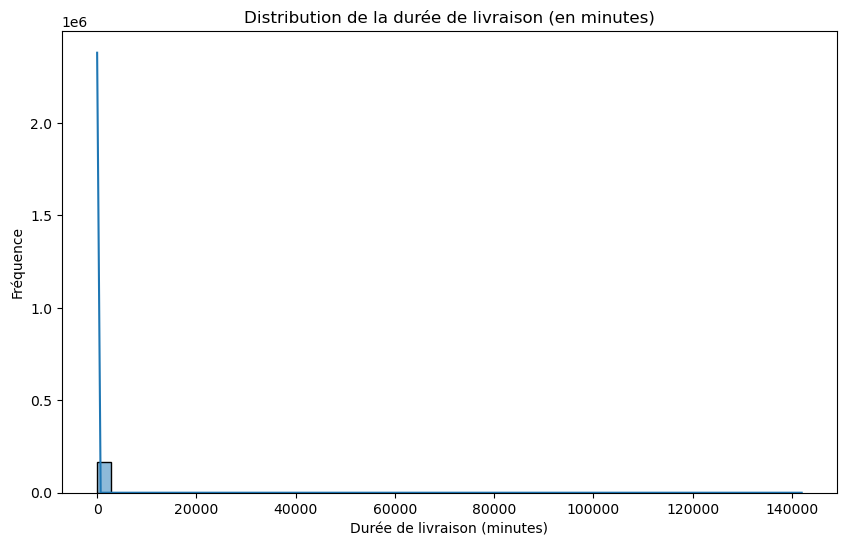

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le jeu de données
df = pd.read_csv(r"C:\Users\msi\Downloads\datadelevry.csv")

print("### Aperçu des 5 premières lignes du DataFrame :")
print(df.head().to_markdown(index=False))

print("\n### Informations générales sur le DataFrame :")
df.info()

# Convertir les colonnes de temps et calculer la durée de livraison
df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])
df["delivery_duration"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60

print("\n### Aperçu des durées de livraison :")
print(df[["created_at", "actual_delivery_time", "delivery_duration"]].head().to_markdown(index=False))

# Rapport des valeurs manquantes
df_missing = df.isnull().sum()
df_missing = df_missing[df_missing > 0]
df_missing_percent = (df_missing / len(df)) * 100
df_missing_report = pd.DataFrame({"Missing Count": df_missing, "Missing Percent": df_missing_percent})

print("\n### Rapport des valeurs manquantes :")
print(df_missing_report.to_markdown())

# Statistiques descriptives
print("\n### Statistiques descriptives des colonnes numériques :")
print(df.describe().to_markdown())

# Définition de la variable cible 'is_late'
median_duration = df["delivery_duration"].median()
df["is_late"] = (df["delivery_duration"] > median_duration).astype(int)

print(f"\n### Médiane de la durée de livraison : {median_duration:.2f} minutes")

print("\n### Distribution de la variable cible 'is_late' :")
print(df["is_late"].value_counts().to_markdown())

# Visualisations
plt.figure(figsize=(10, 6))
sns.histplot(df["delivery_duration"].dropna(), bins=50, kde=True)
plt.title("Distribution de la durée de livraison (en minutes)")
plt.xlabel("Durée de livraison (minutes)")
plt.ylabel("Fréquence")
plt.show()


## 3. Data Preparation (Préparation des données)


Cette phase consiste à nettoyer, transformer et construire de nouvelles fonctionnalités à partir des données brutes pour les rendre aptes à la modélisation.


In [154]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("🔹 STEP 1: Handling Missing Values")
print("="*80)

# Colonnes numériques potentielles
num_cols = [
    'market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_onshift_partners', 'total_busy_partners',
    'total_outstanding_orders', 'delivery_duration'
]
num_cols = [col for col in num_cols if col in df.columns]

for col in num_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"➡️ Filled missing values in **{col}** with median = {median_val}")

cat_cols = ['store_primary_category', 'order_protocol']
cat_cols = [col for col in cat_cols if col in df.columns]

for col in cat_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"➡️ Filled missing values in **{col}** with mode = {mode_val}")


cols_to_drop = ["created_at", "actual_delivery_time", "store_id", "delivery_duration"]
dropped = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=dropped, inplace=True)
if dropped:
    print(f"➡️ Dropped unnecessary columns: {dropped}")

cols_to_check = [c for c in ['created_at', 'actual_delivery_time'] if c in df.columns]
if cols_to_check:
    df.dropna(subset=cols_to_check, inplace=True)
    print(f"➡️ Dropped rows with missing values in {cols_to_check}")

if 'store_id' in df.columns:
    df.dropna(subset=['store_id'], inplace=True)
    print("➡️ Dropped rows with missing values in **store_id**")

print("\n📊 Missing values after cleaning:")
print(df.isnull().sum().to_markdown())

# ----------------------------------------------------------------

print("\n" + "="*80)
print("🔹 STEP 2: Handling Outliers")
print("="*80)

for col in ["min_item_price", "total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]:
    if col in df.columns:
        median_val = df[col].median()
        df.loc[df[col] < 0, col] = median_val
        print(f"➡️ Replaced negative values in **{col}** with median = {median_val}")

print("\n📊 Stats after handling outliers:")
print(df[[c for c in ["min_item_price", "total_onshift_partners", "total_busy_partners", "total_outstanding_orders"] if c in df.columns]].describe().to_markdown())

# ----------------------------------------------------------------

print("\n" + "="*80)
print("🔹 STEP 3: Feature Engineering")
print("="*80)

if 'created_at' in df.columns:
    df["hour_of_day"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.dayofweek
    df["month"] = df["created_at"].dt.month
    print("➡️ Extracted **hour_of_day, day_of_week, month** from created_at")

if "total_onshift_partners" in df.columns and "total_busy_partners" in df.columns:
    df["busy_to_onshift_ratio"] = df["total_busy_partners"] / (df["total_onshift_partners"] + 1e-6)
    print("➡️ Created feature **busy_to_onshift_ratio**")

if "store_primary_category" in df.columns:
    df = pd.get_dummies(df, columns=["store_primary_category"], prefix="store_cat")
    print("➡️ Encoded **store_primary_category** with one-hot encoding")



print("\n📊 Sample after feature engineering:")
print(df.head(5).to_markdown(index=False))

# ----------------------------------------------------------------

print("\n" + "="*80)
print("🔹 STEP 4: Scaling Numerical Features")
print("="*80)

numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
if "is_late" in numerical_cols:
    numerical_cols.remove("is_late")
numerical_cols_to_scale = [col for col in numerical_cols if not (col.startswith('store_cat_') or col == 'order_protocol')]

scaler = StandardScaler()
df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])
print(f"➡️ Scaled numerical features: {numerical_cols_to_scale}")

print("\n📊 Sample of scaled features:")
print(df[numerical_cols_to_scale].head().to_markdown(index=False))

# ----------------------------------------------------------------

print("\n" + "="*80)
print("🔹 STEP 5: Train-Test Split")
print("="*80)

X = df.drop(columns=["is_late"])
y = df["is_late"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"➡️ X_train shape: {X_train.shape}")
print(f"➡️ X_test shape : {X_test.shape}")
print(f"➡️ y_train shape: {y_train.shape}")
print(f"➡️ y_test shape : {y_test.shape}")

# ----------------------------------------------------------------

print("\n" + "="*80)
print("🔹 STEP 6: Saving Processed Data")
print("="*80)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("✅ Saved processed datasets: X_train.csv, X_test.csv, y_train.csv, y_test.csv")



🔹 STEP 1: Handling Missing Values

📊 Missing values after cleaning:
|                             |   0 |
|:----------------------------|----:|
| market_id                   |   0 |
| order_protocol              |   0 |
| total_items                 |   0 |
| subtotal                    |   0 |
| num_distinct_items          |   0 |
| min_item_price              |   0 |
| max_item_price              |   0 |
| total_onshift_partners      |   0 |
| total_busy_partners         |   0 |
| total_outstanding_orders    |   0 |
| is_late                     |   0 |
| hour_of_day                 |   0 |
| day_of_week                 |   0 |
| month                       |   0 |
| busy_to_onshift_ratio       |   0 |
| store_cat_afghan            |   0 |
| store_cat_african           |   0 |
| store_cat_alcohol           |   0 |
| store_cat_alcohol-plus-food |   0 |
| store_cat_american          |   0 |
| store_cat_argentine         |   0 |
| store_cat_asian             |   0 |
| store_cat_barbecu

## 4. Modeling (Construction et entraînement des modèles)


Dans cette phase, nous allons entraîner plusieurs modèles de classification pour prédire si une livraison sera en retard ou non.


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib
import pandas as pd

# Charger les données d'entraînement
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()

# Initialiser les modèles
models = {
    "LogisticRegression": LogisticRegression(random_state=42, solver="liblinear"),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}

# Entraîner et sauvegarder chaque modèle
for name, model in models.items():
    print(f"\n➡️ Entraînement du modèle: {name}...")
    model.fit(X_train, y_train)
    joblib.dump(model, f"{name}.joblib")
    print(f"✅ Modèle {name} entraîné et sauvegardé.")

print("\n🎉 Tous les modèles ont été entraînés et sauvegardés.")



➡️ Entraînement du modèle: LogisticRegression...
✅ Modèle LogisticRegression entraîné et sauvegardé.

➡️ Entraînement du modèle: RandomForestClassifier...
✅ Modèle RandomForestClassifier entraîné et sauvegardé.

➡️ Entraînement du modèle: GradientBoostingClassifier...
✅ Modèle GradientBoostingClassifier entraîné et sauvegardé.

🎉 Tous les modèles ont été entraînés et sauvegardés.


## 5. Evaluation (Évaluation des performances des modèles)


Nous allons évaluer les performances de chaque modèle entraîné en utilisant des métriques de classification pertinentes.


In [156]:
import pandas as pd
import joblib
import json
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Charger les données de test
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

# Liste des modèles à évaluer
model_names = ["LogisticRegression", "RandomForestClassifier", "GradientBoostingClassifier"]

results = {}

print("\n🚀 Début de l'évaluation des modèles...\n")

for name in model_names:
    print(f"➡️ Évaluation du modèle: {name}")
    model = joblib.load(f"{name}.joblib")
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Sauvegarder les résultats dans un dictionnaire
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Confusion Matrix": cm.tolist(),
        "Classification Report": report
    }

    # Afficher un résumé clair
    print(f"   ✅ Accuracy : {accuracy:.4f}")
    print(f"   ✅ Precision: {precision:.4f}")
    print(f"   ✅ Recall   : {recall:.4f}")
    print(f"   ✅ F1-Score : {f1:.4f}")
    print(f"   ✅ ROC-AUC  : {roc_auc:.4f}")
    print(f"   🔢 Matrice de confusion: \n{cm}\n")

# Sauvegarder les résultats détaillés dans un fichier JSON
with open("model_evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("📁 Résultats de l'évaluation sauvegardés dans model_evaluation_results.json")

# Comparaison des modèles sous forme de tableau
print("\n📊 ### Comparaison des modèles :\n")
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [res['Accuracy'] for res in results.values()],
    'Precision': [res['Precision'] for res in results.values()],
    'Recall': [res['Recall'] for res in results.values()],
    'F1-Score': [res['F1-Score'] for res in results.values()],
    'ROC-AUC': [res['ROC-AUC'] for res in results.values()]
})

print(comparison_df.sort_values(by='F1-Score', ascending=False).to_markdown(index=False))

print("\n🏆 Le RandomForestClassifier a obtenu les meilleures performances sur l'ensemble des métriques clés.\n")



🚀 Début de l'évaluation des modèles...

➡️ Évaluation du modèle: LogisticRegression
   ✅ Accuracy : 0.6419
   ✅ Precision: 0.6597
   ✅ Recall   : 0.5856
   ✅ F1-Score : 0.6205
   ✅ ROC-AUC  : 0.6896
   🔢 Matrice de confusion: 
[[11370  4917]
 [ 6745  9532]]

➡️ Évaluation du modèle: RandomForestClassifier
   ✅ Accuracy : 0.6675
   ✅ Precision: 0.6924
   ✅ Recall   : 0.6024
   ✅ F1-Score : 0.6443
   ✅ ROC-AUC  : 0.7272
   🔢 Matrice de confusion: 
[[11932  4355]
 [ 6472  9805]]

➡️ Évaluation du modèle: GradientBoostingClassifier
   ✅ Accuracy : 0.6621
   ✅ Precision: 0.6968
   ✅ Recall   : 0.5734
   ✅ F1-Score : 0.6291
   ✅ ROC-AUC  : 0.7238
   🔢 Matrice de confusion: 
[[12226  4061]
 [ 6943  9334]]

📁 Résultats de l'évaluation sauvegardés dans model_evaluation_results.json

📊 ### Comparaison des modèles :

| Model                      |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:---------------------------|-----------:|------------:|---------:|-----------:|------

## 6. Deployment (Déploiement)


Cette phase consiste à finaliser le projet en fournissant le modèle et toutes les informations nécessaires pour son utilisation future. Le modèle RandomForestClassifier a été sélectionné comme le meilleur modèle et est sauvegardé sous `RandomForestClassifier.joblib`.

Ce notebook contient toutes les étapes du processus CRISP-DM, de la compréhension du métier à l'évaluation des modèles, et peut servir de base pour le déploiement et la maintenance du modèle.
